In [139]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

import warnings
warnings.filterwarnings('ignore')

In [140]:
xgb.__version__

'0.81'

In [141]:
eventos = pd.read_csv('/home/pcsor/datos/events_up_to_01062018.csv',low_memory=False)
train = pd.read_csv('/home/pcsor/datos/labels_training_set.csv',low_memory=False)
test = pd.read_csv('/home/pcsor/datos/trocafone_kaggle_test.csv',low_memory=False)

In [142]:
eventos['timestamp'].min() , eventos['timestamp'].max()

('2018-01-01 08:09:31', '2018-05-31 23:59:59')

In [143]:
eventos.shape

(2341681, 23)

In [144]:
test['label']=2
train = pd.concat([train,test])

In [145]:
train.shape,test.shape

((38829, 2), (19415, 2))

In [146]:
def getBrand(s):
    if (type(s) == float): return None
    parsedBrand = s.split()[0]
    return "Apple" if parsedBrand in {"iPad", "iPhone"} else parsedBrand #Agrupamos iPad e iPhone en Apple
eventos['marca'] = eventos['model'].apply(lambda x: getBrand(x))
brand_counts = eventos['marca'].value_counts()

In [147]:
dummy = eventos.groupby(['person','marca'])['event'].agg(['count']).unstack(level=1).reset_index()
dummy.columns = ['person','Apple','Asus','LG','Lenovo','Motorola','Outros','Quantum','Samsung','Sony','Xiaomi']
train = pd.merge(train,dummy[['person','Apple','Asus','LG','Lenovo','Motorola','Samsung','Sony']],how='left',on='person')

In [148]:
brand_counts

Apple       599266
Samsung     501307
Motorola    162914
LG           24814
Sony         15599
Lenovo       11382
Asus          4536
Quantum       1693
Outros           1
Xiaomi           1
Name: marca, dtype: int64

In [149]:
eventos['timestamp2'] = eventos['timestamp'].apply(lambda t: datetime.strptime(t,'%Y-%m-%d %H:%M:%S'))
eventos['Hora'] = eventos['timestamp2'].dt.strftime("%H").apply(lambda s: int(s))
eventos["DiaMes"] = eventos['timestamp2'].dt.strftime("%d").apply(lambda s: int(s))
eventos["DiaSemana"] = eventos["timestamp2"].dt.strftime("%w").apply(lambda s: int(s))

In [150]:
eventos['EventosDe0-7'] = 0
eventos['EventosDe8-15'] = 0
eventos['EventosDe16-23'] = 0
eventos['EventosDe0-7'].loc[(eventos['Hora']>=0) & (eventos['Hora']<=7)] = 1
eventos['EventosDe8-15'].loc[(eventos['Hora']>=8) & (eventos['Hora']<=15)] = 1
eventos['EventosDe16-23'].loc[(eventos['Hora']>=16) & (eventos['Hora']<=23)] = 1

In [151]:
dummy = eventos.groupby(['person'])['EventosDe0-7'].agg(['sum']).reset_index()
dummy.columns = ['person','EventosDe0-7']
train = pd.merge(train,dummy,how='left',on='person')
dummy = eventos.groupby(['person'])['EventosDe8-15'].agg(['sum']).reset_index()
dummy.columns = ['person','EventosDe8-15']
train = pd.merge(train,dummy,how='left',on='person')
dummy = eventos.groupby(['person'])['EventosDe16-23'].agg(['sum']).reset_index()
dummy.columns = ['person','EventosDe16-23']
train = pd.merge(train,dummy,how='left',on='person')

In [152]:
dummy = eventos.groupby(['person','DiaSemana'])['event'].agg(['count']).unstack(level=1).reset_index()
dummy.columns = ['person','w0','w1','w2','w3','w4','w5','w6']
train = pd.merge(train,dummy,how='left',on='person')

In [153]:
dummy = eventos.groupby(['person','DiaMes'])['event'].agg(['count']).unstack(level=1).reset_index()
dummy.columns = ['person','d1','d2','d3','d4','d5','d6','d7','d8','d9','d10','d11','d12','d13','d14','d15','d16','d17','d18','d19','d20','d21','d22','d23','d24','d25','d26','d27','d28','d29','d30','d31']
dummy = dummy.fillna(0)
train = pd.merge(train,dummy,how='left',on='person')

In [154]:
dummy = eventos.groupby(['person','condition'])['event'].agg(['count']).unstack(level=1).reset_index()
dummy.columns = ['person','Bom','Bom - Sem Touch ID','Excelente','Muito Bom','Novo']
train = pd.merge(train,dummy,how='left',on='person')

In [155]:
dummy = eventos.groupby(['person','device_type'])['event'].agg(['count']).unstack(level=1).reset_index()
dummy.columns = ['person','Computer','Smartphone','Tablet','Unknown']
train = pd.merge(train,dummy[['person','Computer','Smartphone']],how='left',on='person')

In [156]:
eventos['storage'].loc[eventos['storage'] == '16GB'] = 16
eventos['storage'].loc[eventos['storage'] == '32GB'] = 32
eventos['storage'].loc[eventos['storage'] == '64GB'] = 64
eventos['storage'].loc[eventos['storage'] == '128GB'] = 128
eventos['storage'].loc[eventos['storage'] == '8GB'] = 8
eventos['storage'].loc[eventos['storage'] == '256GB']= 256
eventos['storage'].loc[eventos['storage'] == '4GB'] = 4
eventos['storage'].loc[eventos['storage'] == '512MB'] = 0.5
eventos['storage'] = eventos['storage'].fillna(0)
dummy = eventos[['person','storage']].groupby('person').sum().reset_index()
train = pd.merge(train,dummy,how='left',on=['person'])

In [157]:
######################### Eventos
dummy = eventos[['person','event']].groupby('person').count().reset_index()
dummy.columns = ['person','EventosXusuario']
train = pd.merge(train,dummy,how='left',on=['person'])
dummy = eventos.loc[eventos['timestamp']>'2018-05-26 00:00:00']
dummy = dummy[['person','event']].groupby('person').count().reset_index()
dummy.columns = ['person','Eventos5Xusuario']
train = pd.merge(train,dummy,how='left',on=['person'])
dummy = eventos.loc[eventos['timestamp']>'2018-05-31 00:00:00']
dummy = dummy[['person','event']].groupby('person').count().reset_index()
dummy.columns = ['person','Eventos1Xusuario']
train = pd.merge(train,dummy,how='left',on=['person'])
dummy = eventos.loc[eventos['timestamp']>'2018-05-28 00:00:00']
dummy = dummy[['person','event']].groupby('person').count().reset_index()
dummy.columns = ['person','Eventos3Xusuario']
train = pd.merge(train,dummy,how='left',on=['person'])
################# Mayo
dummy = eventos.loc[eventos['timestamp']>'2018-05-16 00:00:00']
dummy = dummy[['person','event']].groupby('person').count().reset_index()
dummy.columns = ['person','Eventos15MayoXusuario']
train = pd.merge(train,dummy,how='left',on=['person'])
dummy = eventos.loc[(eventos['timestamp']>'2018-05-01 00:00:00') & (eventos['timestamp']<'2018-05-16 00:00:00')]
dummy = dummy[['person','event']].groupby('person').count().reset_index()
dummy.columns = ['person','Eventos0MayoXusuario']
train = pd.merge(train,dummy,how='left',on=['person'])

In [158]:
#########################Checkout
dummy = eventos.loc[eventos['event'] == 'checkout']
dummy = dummy[['person','event']].groupby('person').count().reset_index()
dummy.columns = ['person','CheckOutXusuario']
train = pd.merge(train,dummy,how='left',on=['person'])
dummy = eventos.loc[(eventos['timestamp']>'2018-05-26 00:00:00') & (eventos['event'] == 'checkout')]
dummy = dummy[['person','event']].groupby('person').count().reset_index()
dummy.columns = ['person','CheckOut5Xusuario']
train = pd.merge(train,dummy,how='left',on=['person'])
################# Mayo
dummy = eventos.loc[(eventos['timestamp']>'2018-05-16 00:00:00') & (eventos['event']=='checkout')]
dummy = dummy[['person','event']].groupby('person').count().reset_index()
dummy.columns = ['person','CheckOut15MayoXusuario']
train = pd.merge(train,dummy,how='left',on=['person'])

In [159]:
######################### Conversion
dummy = eventos.loc[eventos['event'] == 'conversion']
dummy = dummy[['person','event']].groupby('person').count().reset_index()
dummy.columns = ['person','ConversionXusuario']
train = pd.merge(train,dummy,how='left',on=['person'])
################# Mayo
dummy = eventos.loc[(eventos['timestamp']>'2018-05-16 00:00:00') & (eventos['event']=='conversion')]
dummy = dummy[['person','event']].groupby('person').count().reset_index()
dummy.columns = ['person','Conversion15MayoXusuario']
train = pd.merge(train,dummy,how='left',on=['person'])

In [160]:
######################### Viewed Product
dummy = eventos.loc[eventos['event'] == 'viewed product']
dummy = dummy[['person','event']].groupby('person').count().reset_index()
dummy.columns = ['person','ViewedProductXusuario']
train = pd.merge(train,dummy,how='left',on=['person'])
dummy = eventos.loc[(eventos['timestamp']>'2018-05-26 00:00:00') & (eventos['event']=='viewed product')]
dummy = dummy[['person','event']].groupby('person').count().reset_index()
dummy.columns = ['person','ViewedProduct5Xusuario']
train = pd.merge(train,dummy,how='left',on=['person'])
dummy = eventos.loc[(eventos['timestamp']>'2018-05-31 00:00:00') & (eventos['event']=='viewed product')]
dummy = dummy[['person','event']].groupby('person').count().reset_index()
dummy.columns = ['person','ViewedProduct1Xusuario']
train = pd.merge(train,dummy,how='left',on=['person'])
dummy = eventos.loc[(eventos['timestamp']>'2018-05-28 00:00:00') & (eventos['event']=='viewed product')]
dummy = dummy[['person','event']].groupby('person').count().reset_index()
dummy.columns = ['person','ViewedProduct3Xusuario']
train = pd.merge(train,dummy,how='left',on=['person'])
################# Mayo
dummy = eventos.loc[(eventos['timestamp']>'2018-05-16 00:00:00') & (eventos['event']=='viewed product')]
dummy = dummy[['person','event']].groupby('person').count().reset_index()
dummy.columns = ['person','View15MayoXusuario']
train = pd.merge(train,dummy,how='left',on=['person'])
dummy = eventos.loc[(eventos['timestamp']>'2018-05-01 00:00:00') & (eventos['timestamp']<'2018-05-16 00:00:00')\
                   & (eventos['event']=='viewed product')]
dummy = dummy[['person','event']].groupby('person').count().reset_index()
dummy.columns = ['person','View00MayoXusuario']
train = pd.merge(train,dummy,how='left',on=['person'])

In [161]:
######################### SearchP
dummy = eventos.loc[eventos['event'] == 'searched products']
dummy = dummy[['person','event']].groupby('person').count().reset_index()
dummy.columns = ['person','SearchPXusuario']
train = pd.merge(train,dummy,how='left',on=['person'])
################# Mayo
dummy = eventos.loc[(eventos['timestamp']>'2018-05-16 00:00:00') & (eventos['event']=='searched products')]
dummy = dummy[['person','event']].groupby('person').count().reset_index()
dummy.columns = ['person','Search15MayoXusuario']
train = pd.merge(train,dummy,how='left',on=['person'])

In [162]:
######################### search engine hit
dummy = eventos.loc[eventos['event'] == 'search engine hit']
dummy = dummy[['person','event']].groupby('person').count().reset_index()
dummy.columns = ['person','SearchHXusuario']
train = pd.merge(train,dummy,how='left',on=['person'])
######################### ad campaign hit
dummy = eventos.loc[eventos['event'] == 'ad campaign hit']
dummy = dummy[['person','event']].groupby('person').count().reset_index()
dummy.columns = ['person','adXusuario']
train = pd.merge(train,dummy,how='left',on=['person'])
######################### brand
dummy = eventos.loc[eventos['event'] == 'brand listing']
dummy = dummy[['person','event']].groupby('person').count().reset_index()
dummy.columns = ['person','brandXusuario']
train = pd.merge(train,dummy,how='left',on=['person'])
dummy = eventos.loc[(eventos['timestamp']>'2018-05-16 00:00:00') & (eventos['event']=='brand listing')]
dummy = dummy[['person','event']].groupby('person').count().reset_index()
dummy.columns = ['person','brandeMayo15Xusuario']
train = pd.merge(train,dummy,how='left',on=['person'])
dummy = eventos.loc[(eventos['timestamp']>'2018-05-26 00:00:00') & (eventos['event']=='brand listing')]
dummy = dummy[['person','event']].groupby('person').count().reset_index()
dummy.columns = ['person','brand5Xusuario']
train = pd.merge(train,dummy,how='left',on=['person'])
######################### staticpage
dummy = eventos.loc[eventos['event'] == 'staticpage']
dummy = dummy[['person','event']].groupby('person').count().reset_index()
dummy.columns = ['person','staticpageXusuario']
train = pd.merge(train,dummy,how='left',on=['person'])
dummy = eventos.loc[eventos['event'] == 'visited site']
dummy = dummy[['person','event']].groupby('person').count().reset_index()
dummy.columns = ['person','visitXusuario']
train = pd.merge(train,dummy,how='left',on=['person'])
######################### staticpage
dummy = eventos.loc[eventos['event'] == 'generic listing']
dummy = dummy[['person','event']].groupby('person').count().reset_index()
dummy.columns = ['person','genericXusuario']
train = pd.merge(train,dummy,how='left',on=['person'])
dummy = eventos.loc[(eventos['timestamp']>'2018-05-26 00:00:00') & (eventos['event']=='generic listing')]
dummy = dummy[['person','event']].groupby('person').count().reset_index()
dummy.columns = ['person','generic5Xusuario']
train = pd.merge(train,dummy,how='left',on=['person'])

In [163]:
#### Tasa de conversion por modelo
def most_common(lst):
    return max(set(lst), key=lst.count)
dummy = eventos.loc[eventos['model'].notnull()]
dummy = dummy.groupby('person')['model'].apply(list)
dummy = dummy.map(most_common).reset_index()
train = pd.merge(train,dummy,how='left',on=['person'])
cconversion = eventos.loc[eventos['event']=='conversion']['model'].value_counts().reset_index()
cevento = eventos['model'].value_counts().reset_index()
dummy = pd.merge(cconversion,cevento,how='left',on='index')
dummy['tasa'] = dummy['model_x']/dummy['model_y']
dummy = dummy.loc[dummy['model_y']>10000][['index','tasa']]
dummy.columns = ['model','TasaConversionXmodelo']
train = pd.merge(train,dummy,how='left',on=['model'])
train = train.drop('model',axis=1)

In [164]:
#### Tasa de conversion por ciudad
dummy = eventos.loc[eventos['city'].notnull()]
dummy = dummy.groupby('person')['city'].apply(list)
def most_common(lst):
    return max(set(lst), key=lst.count)
dummy = dummy.map(most_common).reset_index()
train = pd.merge(train,dummy,how='left',on=['person'])
conversionXciudad = train.groupby('city')['ConversionXusuario'].sum()
eventoXciudad = train.groupby('city')['EventosXusuario'].sum()
TasaConversionXciudad = (conversionXciudad/eventoXciudad).fillna(0)
TasaConversionXciudad = TasaConversionXciudad.reset_index()
TasaConversionXciudad.columns = ['city','TasaConversionXciudad']
train = pd.merge(train,TasaConversionXciudad,how='left',on=['city'])
train = train.drop('city',axis=1)

In [165]:
eventos['event'].loc[eventos['event'] == 'visited site'] = 0
eventos['event'].loc[eventos['event'] == 'search engine hit'] = 0
eventos['event'].loc[eventos['event'] == 'ad campaign hit'] = 1
eventos['event'].loc[eventos['event'] == 'staticpage'] = 0
eventos['event'].loc[eventos['event'] == 'generic listing'] = 2
eventos['event'].loc[eventos['event'] == 'searched products']= 1
eventos['event'].loc[eventos['event'] == 'brand listing'] = 2
eventos['event'].loc[eventos['event'] == 'viewed product'] = 3
eventos['event'].loc[eventos['event'] == 'checkout']= 3
eventos['event'].loc[eventos['event'] == 'conversion'] = 8
eventos['event'].loc[eventos['event'] == 'lead']= 8
#dummy = eventos.groupby('person')['event'].apply(list)
dummy = eventos[['person','event']].groupby('person').sum().reset_index()
dummy.columns = ['person','Calificacion']
train = pd.merge(train,dummy,how='left',on=['person'])

In [166]:
test.shape,train.shape

((19415, 2), (38829, 89))

In [167]:
train=train.fillna(0)
x = train.iloc[:,2:].values 
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df.columns = train.iloc[:,2:].keys()
train = pd.concat([train.drop(train.iloc[:,2:].keys(),axis=1),df],axis=1)

In [168]:
test = train.loc[train['label'] == 2]
train = train.loc[train['label'] != 2]
testPerson = test['person']
train_y = train['label']
train = train.drop(['label','person'],axis=1)
test = test.drop(['label','person'],axis=1)

In [169]:
train.shape,test.shape

((19414, 87), (19415, 87))

In [170]:
X_train, X_test, y_train, y_test = train_test_split(train, train_y, test_size=0.5, random_state=2354)
y_test.shape , X_test.shape , X_train.shape, y_train.shape

((9707,), (9707, 87), (9707, 87), (9707,))

In [171]:
train.shape,train_y.shape

((19414, 87), (19414,))

In [172]:
params = {'learning_rate': [0.02],
    'max_depth': [5],
    'gamma': [5.4],
    'n_estimators': [400,500,600],
         'colsample_bylevel':[0.3,0.4,0.45]}
xgb_model = xgb.XGBClassifier(eval_metric='auc',n_jobs=4, early_stopping_rounds=15,silent=True)
clf = GridSearchCV(xgb_model,params,scoring ='roc_auc',cv=5)
#clf.fit(X_train,y_train)
clf.fit(train,train_y)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, early_stopping_rounds=15, eval_metric='auc',
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=4,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.02], 'max_depth': [5], 'gamma': [5.4], 'n_estimators': [400, 500, 600], 'colsample_bylevel': [0.3, 0.4, 0.45]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [173]:
results = pd.DataFrame(clf.cv_results_)
results.sort_values(by='mean_test_score',ascending=False)[0:10]

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_colsample_bylevel,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,params,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
1,2.34,0.02,0.87,0.94,0.30,5.40,0.02,5,500,"{'colsample_bylevel': 0.3, 'gamma': 5.4, 'lear...",...,0.86,0.94,0.89,0.94,0.88,0.94,0.06,0.00,0.01,0.00
2,2.72,0.03,0.87,0.94,0.30,5.40,0.02,5,600,"{'colsample_bylevel': 0.3, 'gamma': 5.4, 'lear...",...,0.86,0.94,0.89,0.94,0.88,0.94,0.04,0.00,0.01,0.00
0,1.89,0.02,0.87,0.93,0.30,5.40,0.02,5,400,"{'colsample_bylevel': 0.3, 'gamma': 5.4, 'lear...",...,0.86,0.94,0.89,0.93,0.88,0.93,0.02,0.00,0.01,0.00
3,2.18,0.02,0.87,0.94,0.40,5.40,0.02,5,400,"{'colsample_bylevel': 0.4, 'gamma': 5.4, 'lear...",...,0.86,0.94,0.88,0.94,0.88,0.94,0.03,0.00,0.01,0.00
4,2.66,0.02,0.87,0.94,0.40,5.40,0.02,5,500,"{'colsample_bylevel': 0.4, 'gamma': 5.4, 'lear...",...,0.86,0.94,0.88,0.94,0.88,0.94,0.01,0.00,0.01,0.00
5,3.15,0.02,0.87,0.94,0.40,5.40,0.02,5,600,"{'colsample_bylevel': 0.4, 'gamma': 5.4, 'lear...",...,0.86,0.94,0.88,0.94,0.88,0.94,0.02,0.00,0.01,0.00
6,2.34,0.02,0.87,0.94,0.45,5.40,0.02,5,400,"{'colsample_bylevel': 0.45, 'gamma': 5.4, 'lea...",...,0.86,0.94,0.89,0.94,0.88,0.94,0.01,0.00,0.01,0.00
7,2.86,0.02,0.87,0.94,0.45,5.40,0.02,5,500,"{'colsample_bylevel': 0.45, 'gamma': 5.4, 'lea...",...,0.86,0.94,0.89,0.94,0.88,0.94,0.01,0.00,0.01,0.00
8,3.40,0.02,0.87,0.94,0.45,5.40,0.02,5,600,"{'colsample_bylevel': 0.45, 'gamma': 5.4, 'lea...",...,0.86,0.94,0.88,0.94,0.87,0.94,0.03,0.00,0.01,0.00


In [174]:
clf.best_score_

0.8730966398230037

In [175]:
clf.best_params_

{'colsample_bylevel': 0.3,
 'gamma': 5.4,
 'learning_rate': 0.02,
 'max_depth': 5,
 'n_estimators': 500}

In [181]:
#clf.best_estimator_.fit(X_train,y_train)
clf.best_estimator_.fit(train,train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.3,
       colsample_bytree=1, early_stopping_rounds=15, eval_metric='auc',
       gamma=5.4, learning_rate=0.02, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=500, n_jobs=4,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [182]:
predic = clf.predict_proba(test)
#predic = clf.best_estimator_.predict_proba(X_test)

In [183]:
predic[:,1]

array([0.00422778, 0.03062188, 0.01121635, ..., 0.07989743, 0.06997079,
       0.08268707], dtype=float32)

<BarContainer object of 32 artists>

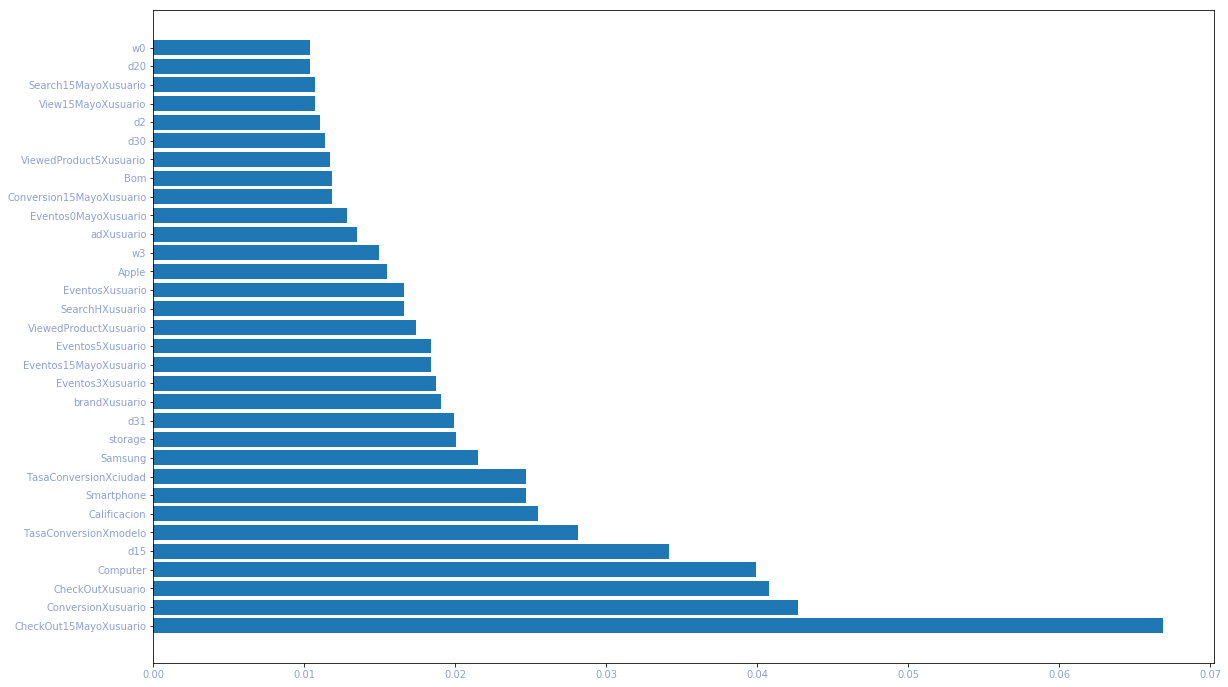

In [184]:
toplot = pd.DataFrame(train.columns.values,clf.best_estimator_.feature_importances_).reset_index()
toplot.columns = ['importancia','features']
toplot = toplot.sort_values(by='importancia',ascending=False)[0:32]
plt.figure(figsize=(19,12))
plt.xticks(rotation=0,fontsize=10,color='#90A0D4')
plt.yticks(fontsize=10,color='#90A0D4')
plt.barh(toplot['features'],toplot['importancia'])

In [180]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test.values, predic[:,1])

0.8678577427354733

In [185]:
submit = pd.DataFrame()
submit['person'] = testPerson
submit['label'] = predic[:,1]

In [186]:
submit.to_csv('/home/pcsor/datos/submit3.csv',index=False)

In [115]:

import tensorflow as tf
mnist = tf.keras.datasets.mnist


X_train, X_test, y_train, y_test = train_test_split(train.values, train_y.values, test_size=0.5, random_state=9235)
#(x_train, y_train),(x_test, y_test) = mnist.load_data()
#x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(350, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(64, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(9, activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(3, activation=tf.nn.softmax),
])
model.compile(optimizer='adamax',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20)
predic = model.predict_proba(X_test)

Epoch 1/20
9707/9707 [==============================] - 2s 158us/step - loss: 0.2460 - acc: 0.9439
Epoch 2/20
9707/9707 [==============================] - 0s 47us/step - loss: 0.1981 - acc: 0.9491
Epoch 3/20
9707/9707 [==============================] - 0s 44us/step - loss: 0.1939 - acc: 0.9491
Epoch 4/20
9707/9707 [==============================] - 0s 41us/step - loss: 0.1910 - acc: 0.9491
Epoch 5/20
9707/9707 [==============================] - 0s 43us/step - loss: 0.1888 - acc: 0.9491
Epoch 6/20
9707/9707 [==============================] - 0s 41us/step - loss: 0.1865 - acc: 0.9491
Epoch 7/20
9707/9707 [==============================] - 0s 51us/step - loss: 0.1826 - acc: 0.9491
Epoch 8/20
9707/9707 [==============================] - 0s 43us/step - loss: 0.1803 - acc: 0.9491
Epoch 9/20
9707/9707 [==============================] - 0s 43us/step - loss: 0.1768 - acc: 0.9491
Epoch 10/20
9707/9707 [==============================] - 0s 42us/step - loss: 0.1721 - acc: 0.9493
Epoch 11/20
9707/9

In [116]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, predic[:,1])

0.8325370430619319